In [1]:
import os
os.chdir('..') # this resolves ImportError: attempted relative import with no known parent package

# general DS packages
import pandas as pd
import numpy as np

# cleaning and pre-processing
from nltk.tokenize import RegexpTokenizer
from src.processing.text_cleaning import (normalize_text, process_contractions, remove_all_punctuation, remove_emojis, 
remove_html_unescape, remove_href_pattern, remove_digits, remove_extra_whitespace, remove_website_links)

from src.processing.text_processing import (tokenize_comment, lemmatize_comment, remove_stop_words, remove_tiny_tokens, 
remove_tekken_character_names_from_tokens, part_of_speech, part_of_speech_tag, part_of_speech_dependency, part_of_speech_shape, 
part_of_speech_alpha, part_of_speech_is_stop, word_count, unique_words_from_tokens)

from src.modeling.topic_dataframe import topic_dataframe, _heaviest_words_indices

# modeling
import gensim
from gensim import corpora
from gensim.corpora.dictionary import Dictionary
from gensim.models.nmf import Nmf
from gensim.models.coherencemodel import CoherenceModel
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# visualisation
import matplotlib.pyplot as plt

# other
from operator import itemgetter

In [2]:
# import data from csv
raw_data = pd.read_csv("data/raw/new_character_reveal_comments.csv", )
data = raw_data.copy()
df = pd.DataFrame(data)

# Clean and process dataframe

In [3]:
%%time

# clean
df['textDisplay'] = df['textDisplay'].apply(normalize_text)
df['textDisplay'] = df['textDisplay'].apply(process_contractions)
df['textDisplay'] = df['textDisplay'].apply(remove_website_links)
df['textDisplay'] = df['textDisplay'].apply(remove_html_unescape)
df['textDisplay'] = df['textDisplay'].apply(remove_emojis)
df['textDisplay'] = df['textDisplay'].apply(remove_digits)
df['textDisplay'] = df['textDisplay'].apply(remove_all_punctuation)
df['textDisplay'] = df['textDisplay'].apply(remove_href_pattern)
df['textDisplay'] = df['textDisplay'].apply(remove_extra_whitespace)

# process
df["textDisplayWordCount"] = df['textDisplay'].apply(word_count)
df["textStopWordsRemoved"] = df["textDisplay"].apply(remove_stop_words)
df["textTokenized"] = df['textStopWordsRemoved'].apply(tokenize_comment)
df["textLemmatized"] = df["textStopWordsRemoved"].apply(lemmatize_comment)
# remove short meaningless tokens from lemmatized tokens
df["textLemmatized"] = df['textLemmatized'].apply(remove_tiny_tokens)
df["textTekkenCharactersRemoved"] = df["textLemmatized"].apply(remove_tekken_character_names_from_tokens)
df["textProcessedCharactersRemoved"] = df["textTekkenCharactersRemoved"].apply(lambda x: ' '.join(x))

# part of speech operations
df["pos"] = df["textStopWordsRemoved"].apply(part_of_speech)
df["posTag"] = df["textStopWordsRemoved"].apply(part_of_speech_tag)
df["posDependency"] = df["textStopWordsRemoved"].apply(part_of_speech_dependency)
df["posShape"] = df["textStopWordsRemoved"].apply(part_of_speech_shape)
df["posAlpha"] = df["textStopWordsRemoved"].apply(part_of_speech_alpha)
df["posStopWord"] = df["textStopWordsRemoved"].apply(part_of_speech_is_stop)


# remove rows with empty strings in the 'textProcessedCharactersRemoved' column as these will have nothing to pass to the vectorizer when we come to transforming the text input
# to numerical input
df = df[df["textProcessedCharactersRemoved"].astype(str) != '']
df.reset_index(drop=True, inplace=True)

df.head()

CPU times: user 38.9 s, sys: 37.8 ms, total: 38.9 s
Wall time: 39.1 s


,videoId,authorDisplayName,publishedAt,updatedAt,likeCount,totalReplyCount,textDisplay,textDisplayWordCount,textStopWordsRemoved,textTokenized,textLemmatized,textTekkenCharactersRemoved,textProcessedCharactersRemoved,pos,posTag,posDependency,posShape,posAlpha,posStopWord
0,rDxrpSqYHD8,@faizaanjaved7150,2023-11-01 16:10:05+00:00,2023-11-01 16:10:05+00:00,1,1,already seen it you are getting less views now...,10,seen getting views bamco,"[seen, getting, views, bamco]","[see, get, view, bamco]","[see, get, view, bamco]",see get view bamco,"[VERB, VERB, NOUN, NOUN]","[VBN, VBG, NNS, NNS]","[ROOT, xcomp, dobj, dobj]","[xxxx, xxxx, xxxx, xxxx]","[True, True, True, True]","[False, False, False, False]"
1,rDxrpSqYHD8,@TS-rw4lk,2023-11-01 16:10:05+00:00,2023-11-01 16:10:05+00:00,0,0,wow,1,wow,[wow],[wow],[wow],wow,[INTJ],[UH],[ROOT],[xxx],[True],[False]
2,rDxrpSqYHD8,@ALONCAK,2023-11-01 16:10:06+00:00,2023-11-01 16:10:06+00:00,0,0,oww yeaah,2,oww yeaah,"[oww, yeaah]","[oww, yeaah]","[oww, yeaah]",oww yeaah,"[PROPN, PROPN]","[NNP, NNP]","[compound, ROOT]","[xxx, xxxx]","[True, True]","[False, False]"
3,rDxrpSqYHD8,@Rough_Estimates,2023-11-01 16:10:06+00:00,2023-11-01 16:10:06+00:00,135,14,i hope we get an angel version of jin,9,hope angel version jin,"[hope, angel, version, jin]","[hope, angel, version, jin]","[hope, version]",hope version,"[PROPN, PROPN, PROPN, PROPN]","[NNP, NNP, NNP, NNP]","[compound, compound, compound, ROOT]","[xxxx, xxxx, xxxx, xxx]","[True, True, True, True]","[False, False, False, False]"
4,rDxrpSqYHD8,@kazamataurus337,2023-11-01 16:10:08+00:00,2023-11-01 16:10:08+00:00,1,0,so it begins,3,begins,[begins],[begin],[begin],begin,[VERB],[VBZ],[ROOT],[xxxx],[True],[False]


# NMF model
- At this point we have the text processed and avaibale in tokenized format and as a string
- We now need to turn the text into numbers
    - this can be done in a variety of ways e.g., TF-IDF, bag of words (which we previously used gensim to create as part of the LDA model)
    - We're going to use TF-IDF to create the features
- Once the features are created we can then create a topic model

### How NMF works
- Using the original input matrix (A) (and this input matrix is our text vectorized), NMF will give you two matrices (W and H).
- W is the topics it found and H is the coefficients (weights) for those topics.
- In other words, A is articles by words (original), H is articles by topics and W is topics by words.


So assuming 301 articles, 5000 words and 30 topics we would get the following 3 matrices:

        A = tfidf_vectorizer.transform(texts)
        W = nmf.components_
        H = nmf.transform(A)

        A = 301 x 5000
        W = 30 x 5000
        H = 301 x 30


- NMF will modify the initial values of W and H so that the product approaches A until either the approximation error converges or the max iterations are reached.
- In our case, the high-dimensional vectors are going to be tf-idf weights.

In [4]:
# turn the words into numbers
texts = df['textTekkenCharactersRemoved']

tfidf_vectorizer = TfidfVectorizer(
    min_df=3,  # ignore words that appear in less than x of the youtube comments
    max_df=0.85,   # ignore words that appear in more than x% of the comments
    max_features=999,   # each word will become a feature, set the max we want
    ngram_range=(1, 2),   # allow tf-idf weights for bigrams
    preprocessor=' '.join   # the model will tokenize everything by default so we need to join the tokenized words
)

In [5]:
# fit and transform the text input
tfidf = tfidf_vectorizer.fit_transform(texts)

## Create NMF model
- Manually set the number of topics to discover to 10; we'll use coherence score later to determine the best number of topics

In [6]:
# create and fit the NMF model with scikit-learn NMF
nmf = NMF(
    n_components=10,   # manually select number of topics
    init='nndsvd',   # ‘nndsvd’ initialiser works well on sparse data
    max_iter=100,
    random_state=42
).fit(tfidf)

In [7]:
nmf

NMF(init='nndsvd', max_iter=100, n_components=10, random_state=42)

## scikit-learn to gensim to scikit-learn...
- scikit-learn's NMF implementations enables us to use TF-IDF, however scikit-learn's NMF model doesn't have a coherence score method.
- We need the coherence score to help determine the optimal number of topics.
- So, we'll use gensim's Nmf and coherence score to get the optimum number of topics and then manually select this number of topics with scikit-learn's implementation so we can use TF-IDF instead of gensim's bag of words approach.

- **NOTE**: TF-IDF is superior to Bag of Words because:
    - Both are common ways of representing text representation in numerical format.
    - TF-IDF addresses the weaknesses of Bag of Words, namely TF-IDF:
        - de-emphasises common words and focusses on unique words
        - results in sparser feature vectors, with many zero values corresponding to irrelevant words. This can be beneficial for certain machine learning algorithms that perform better with sparse data, leading to improved model performance and interpretability.
        - the above helps overcome the word frequency bias that occurs with BoW which simply counts word occurrences, favoring frequent words regardless of their significance.

In [8]:
# use Gensim's Nmf to get the most optimal number of topics via coherence score
texts = df['textTekkenCharactersRemoved']

# create a dictionary - a gensim dictionary is a mapping between words and their integer id
dictionary = Dictionary(texts)

# filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=3, no_above=0.85, keep_n=5000)

# create the bag-of-words format (list of (token_id, token_count))
corpus = [dictionary.doc2bow(text) for text in texts]

# create a list of the topic numbers we want to try
topic_numbers = list(np.arange(5, 50, 5))

# Run the nmf model and calculate the coherence score for each number of topics
coherence_scores = []

for number in topic_numbers:
    nmf = Nmf(
        corpus=corpus,
        num_topics=number,
        id2word=dictionary,
        chunksize=1000,   # number of documents to process at a time during model training, impacts memory usage and computational efficiency
        passes=5,   # number of complete passes over the corpus during training; more passes leads to better topic refinement but increases time
        kappa=.1,    # regularization parameter that controls model sparsity. Higher values encourage sparser topics, potentially leading to more distinct and interpretable results.
        minimum_probability=0.01,   # The minimum probability threshold for filtering out low-probability words from topics; helps focus on the most representative words for each topic.
        w_max_iter=300,   # The maximum number of iterations for updating the W (document-topic) and H (topic-word) matrices, respectively. 
                          # They control model convergence and can be adjusted based on model complexity and dataset size.
        w_stop_condition=0.0001,   # The convergence thresholds for W and H updates. Training stops when changes in these matrices fall below these thresholds.
        h_max_iter=100,
        h_stop_condition=0.001,
        eval_every=10,   # Evaluate model perplexity on the corpus every eval_every iterations.
        normalize=True,   # Normalize document vectors before NMF factorization. It can improve convergence and topic quality in some cases.
        random_state=42
    )
    
    # Run the coherence model to get the score
    coherence_model = CoherenceModel(
        model=nmf,
        texts=texts,
        dictionary=dictionary,
        coherence='c_v'
    )
    
    coherence_scores.append(round(coherence_model.get_coherence(), 3))

# Get the number of topics with the highest coherence score
scores = list(zip(topic_numbers, coherence_scores))
best_number_of_topics = sorted(scores, key=itemgetter(1), reverse=True)[0][0]    # access the first element of the (number_of_topics, coherence score) tuple
                                                                                 # key=itemgetter(1) specifies that the sorting should be done using the value 
                                                                                 # at index 1 of each element as the key (the coherence score)
best_number_of_topics

35

In [9]:
sorted(scores, key=itemgetter(1), reverse=True)[0][0]

35

## Visualise coherence score and number of topics

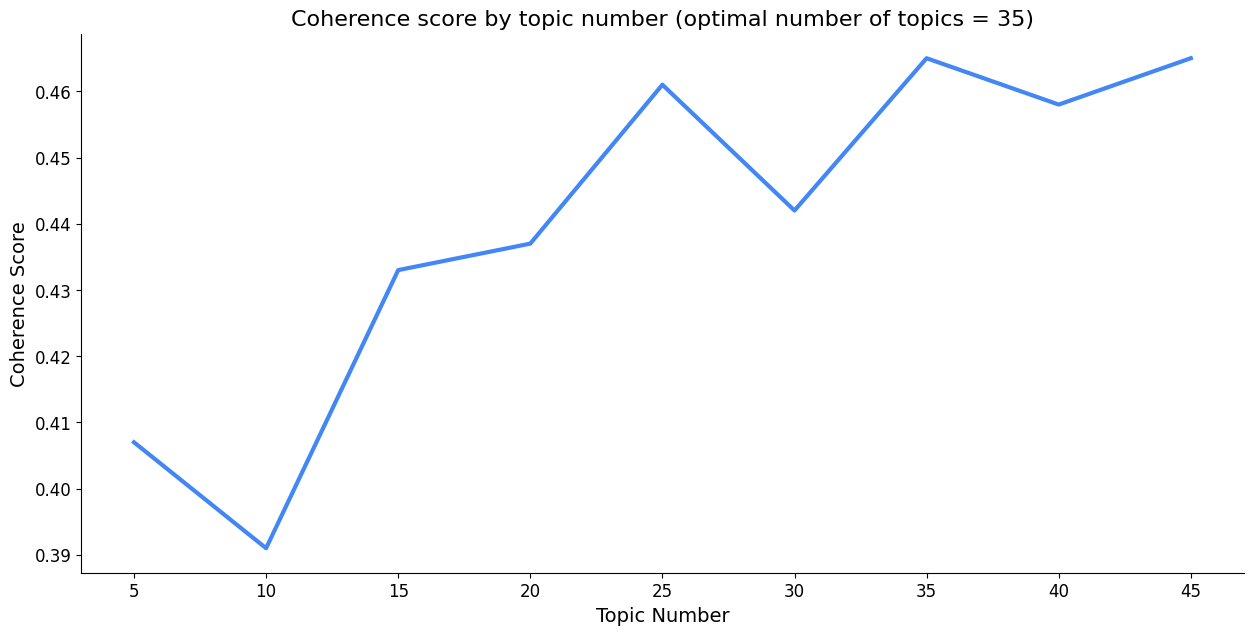

Number of topics with highest coherence score: 35
Coherence score: 0.465


In [46]:
fig, ax = plt.subplots(figsize=(15, 7))

plt.plot(
    topic_numbers,
    coherence_scores,
    linewidth=3,
    color='#4287f5'
)

plt.xlabel("Topic Number", fontsize=14)
plt.ylabel("Coherence Score", fontsize=14)
plt.title(f"Coherence score by topic number (optimal number of topics = {best_number_of_topics})", fontsize=16)
plt.xticks(np.arange(5, max(topic_numbers) + 1, 5), fontsize=12)
plt.yticks(fontsize=12)

# remove plot box outline (spines)
spines = ax.spines
spines['top'].set_visible(False)
spines['right'].set_visible(False)
# ax.tick_params(bottom=False, left=False)

plt.show()

# print summary
print(f"Number of topics with highest coherence score: {best_number_of_topics}\n"
      f"Coherence score: {[item[1] for item in scores if item[0] == best_number_of_topics][0]}")


# save image
fig.savefig(f"images/coherence_score_{[item[1] for item in scores if item[0] == best_number_of_topics][0]}_number_of_topics_{best_number_of_topics}.png")

## Number of topics
- 35 seems like a lot... we'll likely need to experiment with this number. We can see that 5 topics has a coherence score of 0.41 so this may well be fine for the use case as 5 key topics seems more sensible.
- What's more important is the words making up these topics
- Trial and error and experimentation may find more optimal topic numbers, and once we can see what words are making up each topic then we'll be able to ascertain:
    1. If the topics make sense
    2. If there is any similarity between topics.

## Creating valubale topics from the most heavily weighted words
- Because topic modeling is a form of unsupervised learning, summarising the topics can be a challenge.
- One solution is to go through the texts and manually create topics, but this is laborious.
- Another option is to use the words in each topic that had the highest score for that topic and map these back to the feature names.
- Let'stry with the top 5 words for each topic.

# NMF model with 5 topics

In [11]:
# set the text input that we'll transform into numerical format
texts = df['textTekkenCharactersRemoved']

In [12]:
# Create the tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=3,  # discard words in less than 3 documents
    max_df=0.85,    # discard words in more than 85% of documents
    max_features=999, 
    ngram_range=(1, 2),   # enable bigrams
    preprocessor=' '.join   # joins each list of words within a document into a single string, creating the expected string 
                            # representation for each document.
)

In [13]:
tfidf_vectorizer

TfidfVectorizer(max_df=0.85, max_features=999, min_df=3, ngram_range=(1, 2),
                preprocessor=<built-in method join of str object at 0x100f692b0>)

In [14]:
# fit and transform the input text
tfidf = tfidf_vectorizer.fit_transform(texts)   # fit learns the vocab (terms) and frequencies, transform takes the knowledge gained 
                                                # during fit and applies it to transform raw text into a structured, numerical 
                                                # representation that machines can effectively analyze 

In [15]:
# store the feature names in a variable - we'll use these later for topic summaries
tfidf_feature_names = tfidf_vectorizer.get_feature_names_out()

In [16]:
len(tfidf_feature_names)

553

There are 553 features (words)..

In [17]:
tfidf_feature_names

array(['able', 'absolutely', 'actor', 'actual', 'actually',
       'actually look', 'add', 'aesthetic', 'akuma', 'alisas', 'alright',
       'amazing', 'ancient', 'announce', 'anymore', 'appear',
       'appearance', 'armorke', 'armour', 'armpit', 'art', 'ask', 'ass',
       'awesome', 'baby', 'background', 'background music', 'bad',
       'badass', 'baki', 'baki yujiro', 'ball', 'bamco', 'bandai',
       'bandai namco', 'base', 'base game', 'base roster', 'battle',
       'bear', 'beat', 'beautiful', 'beg', 'believe', 'bet', 'beta',
       'big', 'bit', 'black', 'black goku', 'boi', 'boss', 'bout', 'boy',
       'brand', 'brand new', 'bri', 'bring', 'bring character', 'bro',
       'buy', 'buy game', 'buying', 'cameo', 'canon', 'capcom',
       'capoeira', 'care', 'cast', 'chan', 'chance', 'change', 'chaobla',
       'char', 'character', 'character come', 'character design',
       'character far', 'character game', 'character like',
       'character new', 'character not', 'characte

In [18]:
# create an NMF model
nmf = NMF(
    n_components=5,   # number of topics to be extracted
    init='nndsvd',  # initialization method for the non-negative matrices; 'nndsvd' works well on sparse data
    max_iter=200,   # Maximum number of iterations for the optimization algorithm. Higher values lead to better convergence but increase computation time.
    l1_ratio=0.0,   # Regularization parameter controlling balance between L1 and L2 penalties for sparsity; 0.0 (default): No L1 penalty, only L2 penalty.
    solver='cd',    # Optimization algorithm used for NMF. 'cd' (default): Coordinate Descent. 'mu': Multiplicative Update.
    alpha_W=0.0,    # Regularization parameter for the W matrix (document-topic matrix); 0.0 (default): No regularization.
    tol=0.0001,     # Convergence tolerance for the optimization algorithm. Training stops when the change in error falls below this threshold.
    random_state=42
).fit(tfidf)

We can check out the weights given to each word in a given topic by exploring _nmf_components\__ which is an array, with each item in the array containing an array of the feature (word) weights.

In [19]:
# nmf_components_ contains each topic and the weighting of each feature (word), so this is a list of length x (optimal number of topics)
# and each item in the list is an array of feature (word) weights
nmf.components_

array([[0.        , 0.        , 0.        , ..., 0.0018304 , 0.00046031,
        0.        ],
       [0.00364665, 0.        , 0.00022571, ..., 0.00342711, 0.00453954,
        0.        ],
       [0.03716244, 0.01443962, 0.00917603, ..., 0.00789746, 0.00120778,
        0.        ],
       [0.01432602, 0.        , 0.        , ..., 0.03016136, 0.00567045,
        0.        ],
       [0.00159229, 0.        , 0.        , ..., 0.00441627, 0.00445237,
        0.        ]])

In [20]:
# length should be the optimal number of topics
len(nmf.components_)

5

In [21]:
# length of the array for a given topic should be the same as the number of features (553)
len(nmf.components_[0])

553

## Exploring the words and topics

- We now have a model created with the 'optimal' number of topics (as defined by the highest coherence score). We also have the feature names stored in 'tfidf_feature_names'. 
- The next step is to see what words make up each topic and what the topics are, and, ultimately, we want to use the most important words, as determined by the TF-IDF weightage, to create 'topics'.
- To do this we...
    - Create a 'document_weights' variable; this will be a matrix that will tell us which topic each document most closely aligns to, e.g., \[10,3\] would mean that document 10 most closely aligns with topic 3. By examining the values in this matrix, you can understand how documents are distributed across the topics and identify which documents are most representative of each topic.
    - To do this we will:
        - Use the tf-idf vectorizer to transform our text input into a numerical representation, this will be a matrix.
        - Use the NMF model to decompose the matric into a a topics matrix and a documents matrix.
        - Applying the NMF model essentially links each document to a topic.  

In [22]:
# convert text document into numerical tf-idf representation and apply nmf model to this
document_weights = nmf.transform(tfidf_vectorizer.transform(texts))

In [47]:
# set the number of words we want to use (the top x many)
number_of_words = 15

df_topic = topic_dataframe(model=nmf, 
                           feature_names=tfidf_feature_names, 
                           number_of_words=number_of_words
                          ).T    # .T transposes the dataframe

df_topic.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,need,man,trailer,happy,bro,baki,main,know,plz,bear,add,need bring,guest,dlc,music
1,bring,akuma,bro,miss,plz,need bring,dragunov,harada,cmon,crime,bring character,hope bring,lol,fighter,queen


We have a dataframe that contains the top x most heavily weighted (important) words for a given topic. Now we'll create a dataframe that houses the topic number and a string of the words that are most closely linked with the topic.

In [48]:
# perform operations to bring together the top x words and create a string of topic words
df_topic['topic_words'] = df_topic.apply(lambda x: [' '.join(x)], axis=1) # apply row (axis=1) operation that takes the word from each column and 
                                                                     # turns it into a list
df_topic['topic_words'] = df_topic['topic_words'].str[0]  # returns the str of first item in single item list (essentially removes the list brackets)
df_topic['topic_words'] = df_topic['topic_words'].apply(lambda x: tokenize_comment(x)) # tokenize
df_topic['topic_words'] = df_topic['topic_words'].apply(lambda x: unique_words_from_tokens(x))  # Removing duplicate words
df_topic['topic_words'] = df_topic['topic_words'].apply(lambda x: [' '.join(x)])  # returns a single item list where the item is a single string
df_topic['topic_words'] = df_topic['topic_words'].str[0]  # returns the str of first item in single item list (essentially removes the list brackets)


df_topic.head(3)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,topic_words
0,need,man,trailer,happy,bro,baki,main,know,plz,bear,add,need bring,guest,dlc,music,need man trailer happy bro baki main know plz bear add bring guest dlc music
1,bring,akuma,bro,miss,plz,need bring,dragunov,harada,cmon,crime,bring character,hope bring,lol,fighter,queen,bring akuma bro miss plz need dragunov harada cmon crime character hope lol fighter queen
2,character,wait,game,look,new,come,like,trailer,new character,not,main,get,look like,love,return,character wait game look new come like trailer not main get love return


In [49]:
pd.set_option('display.max_colwidth', None) 

# create a dataframe with only the topics and topic number
df_topic = df_topic['topic_words'].reset_index()
df_topic.columns = ['topic_number', 'topic_words']

df_topic

,topic_number,topic_words
0,0,need man trailer happy bro baki main know plz bear add bring guest dlc music
1,1,bring akuma bro miss plz need dragunov harada cmon crime character hope lol fighter queen
2,2,character wait game look new come like trailer not main get love return
3,3,want play baki trailer point add release boy people dlc not slim join yujiro
4,4,hope return announce spot reveal fighter make amazing happy man get add roster


We now have our 5 topics and the top 10 words that are most closely associated with these topics...

# Assessment of model

### Coherence




### Topic interpretability (subjective)




